In [1]:
# Data
import numpy as np

with open('data/text_data/japan.txt', 'r') as f:
# with open('data/text_data/anna.txt', 'r') as f:

    txt = f.read()

    X = []
    y = []

    char_to_idx = {char: i for i, char in enumerate(set(txt))}
    idx_to_char = {i: char for i, char in enumerate(set(txt))}

    X = np.array([char_to_idx[x] for x in txt])
    y = [char_to_idx[x] for x in txt[1:]]
    y.append(char_to_idx['.'])
    y = np.array(y)

In [2]:
# Model or Network
import impl.layer as l
from impl.loss import *

class GRU:
    def __init__(self, D, H, L, char2idx, idx2char):
        self.D = D
        self.H = H
        self.L = L
        self.char2idx = char2idx
        self.idx2char = idx2char
        self.vocab_size = len(char2idx)
        self.losses = {'train':[], 'smooth train':[]}
        
        # Model params: output and input sequence
        Z = H + D
        m = dict(
            Wz=np.random.randn(Z, H) / np.sqrt(Z / 2.),
            Wr=np.random.randn(Z, H) / np.sqrt(Z / 2.),
            Wh=np.random.randn(Z, H) / np.sqrt(Z / 2.),
            Wy=np.random.randn(H, D) / np.sqrt(H / 2.),
            bz=np.zeros((1, H)),
            br=np.zeros((1, H)),
            bh=np.zeros((1, H)),
            by=np.zeros((1, D))
        )

        self.model = []        
        self.model.append([])
        for _ in range(0, self.L - 1, 1):
            self.model[0].append(m)

        self.model.append([])
        for _ in range(self.L):
            self.model[1].append(m)

        # Input sequence - last layer
        m = dict(
            Wz=np.random.randn(Z, H) / np.sqrt(Z / 2.),
            Wr=np.random.randn(Z, H) / np.sqrt(Z / 2.),
            Wh=np.random.randn(Z, H) / np.sqrt(Z / 2.),
            bz=np.zeros((1, H)),
            br=np.zeros((1, H)),
            bh=np.zeros((1, H)),
        )
        for _ in range(self.L - 1, self.L, 1):
            self.model[0].append(m)

    def initial_state(self):
        return np.zeros((1, self.H))

    def forward(self, X, h, m):
        Wz, Wr, Wh, Wy = m['Wz'], m['Wr'], m['Wh'], m['Wy']
        bz, br, bh, by = m['bz'], m['br'], m['bh'], m['by']

        X_in = X.copy()
        h_in = h.copy()

        X = np.column_stack((h_in, X_in))

        hz, hz_cache = l.fc_forward(X, Wz, bz)
        hz, hz_sigm_cache = l.sigmoid_forward(hz)

        hr, hr_cache = l.fc_forward(X, Wr, br)
        hr, hr_sigm_cache = l.sigmoid_forward(hr)

        X = np.column_stack((hr * h_in, X_in))
        
        hh, hh_cache = l.fc_forward(X, Wh, bh)
        hh, hh_tanh_cache = l.tanh_forward(hh)

        # h = (1. - hz) * h_old + hz * hh
        # or
        h = ((1. - hz) * h_in) + (hz * hh)
        # or
        # h = h_in + hz (hh - h_in)

        y, y_cache = l.fc_forward(h, Wy, by)

        cache = (h_in, hz, hz_cache, hz_sigm_cache, hr, hr_cache, hr_sigm_cache, hh, hh_cache, hh_tanh_cache, y_cache)

        return y, h, cache

    def backward(self, dy, dh, cache):
        h_in, hz, hz_cache, hz_sigm_cache, hr, hr_cache, hr_sigm_cache, hh, hh_cache, hh_tanh_cache, y_cache = cache
        
        dh_out = dh.copy()

        dh, dWy, dby = l.fc_backward(dy, y_cache)
        dh += dh_out

        dh_in1 = (1. - hz) * dh
        dhh = hz * dh
        dhz = (hh * dh) - (h_in * dh)
        # or
        # dhz = (hh - h_in) * dh

        dhh = l.tanh_backward(dhh, hh_tanh_cache)
        dXh, dWh, dbh = l.fc_backward(dhh, hh_cache)

        dh = dXh[:, :self.H]
        dX_in2 = dXh[:, self.H:]
        dh_in2 = hr * dh

        dhr = h_in * dh
        dhr = l.sigmoid_backward(dhr, hr_sigm_cache)
        dXr, dWr, dbr = l.fc_backward(dhr, hr_cache)

        dhz = l.sigmoid_backward(dhz, hz_sigm_cache)
        dXz, dWz, dbz = l.fc_backward(dhz, hz_cache)

        dX = dXr + dXz
        dh_in3 = dX[:, :self.H]
        dX_in1 = dX[:, self.H:]

        dh = dh_in1 + dh_in2 + dh_in3
        dX = dX_in1 + dX_in2

        grad = dict(Wz=dWz, Wr=dWr, Wh=dWh, Wy=dWy, bz=dbz, br=dbr, bh=dbh, by=dby)
        
        return dX, dh, grad

    def forward_(self, X, h, m):
        Wz, Wr, Wh = m['Wz'], m['Wr'], m['Wh']
        bz, br, bh = m['bz'], m['br'], m['bh']

        X_in = X.copy()
        h_in = h.copy()

        X = np.column_stack((h_in, X_in))

        hz, hz_cache = l.fc_forward(X, Wz, bz)
        hz, hz_sigm_cache = l.sigmoid_forward(hz)

        hr, hr_cache = l.fc_forward(X, Wr, br)
        hr, hr_sigm_cache = l.sigmoid_forward(hr)

        X = np.column_stack((hr * h_in, X_in))
        
        hh, hh_cache = l.fc_forward(X, Wh, bh)
        hh, hh_tanh_cache = l.tanh_forward(hh)

        # h = (1. - hz) * h_old + hz * hh
        # or
        h = ((1. - hz) * h_in) + (hz * hh)
        # or
        # h = h_in + hz (hh - h_in)

        cache = (h_in, hz, hz_cache, hz_sigm_cache, hr, hr_cache, hr_sigm_cache, hh, hh_cache, hh_tanh_cache)

        return h, cache

    def backward_(self, dh, cache):
        h_in, hz, hz_cache, hz_sigm_cache, hr, hr_cache, hr_sigm_cache, hh, hh_cache, hh_tanh_cache = cache
        
        dh_in1 = (1. - hz) * dh
        dhh = hz * dh
        dhz = (hh * dh) - (h_in * dh)
        # or
        # dhz = (hh - h_in) * dh

        dhh = l.tanh_backward(dhh, hh_tanh_cache)
        dXh, dWh, dbh = l.fc_backward(dhh, hh_cache)

        dh = dXh[:, :self.H]
        dX_in2 = dXh[:, self.H:]
        dh_in2 = hr * dh

        dhr = h_in * dh
        dhr = l.sigmoid_backward(dhr, hr_sigm_cache)
        dXr, dWr, dbr = l.fc_backward(dhr, hr_cache)

        dhz = l.sigmoid_backward(dhz, hz_sigm_cache)
        dXz, dWz, dbz = l.fc_backward(dhz, hz_cache)

        dX = dXr + dXz
        dh_in3 = dX[:, :self.H]
        dX_in1 = dX[:, self.H:]

        dh = dh_in1 + dh_in2 + dh_in3
        dX = dX_in1 + dX_in2

        grad = dict(Wz=dWz, Wr=dWr, Wh=dWh, bz=dbz, br=dbr, bh=dbh)
        
        return dX, dh, grad
    
    def train_forward(self, XY_train, h):
        ys, caches = [], []
        h_init = h.copy()
        h = []
        for _ in range(self.L):
            h.append(h_init.copy())

        # number of sequences: in & out
        for _ in range(2):
            caches.append([])
        
        # number of layers
        for _ in range(self.L):
            caches[0].append([])
            caches[1].append([])
            
        # in and out sequences
        X_train, Y_train = XY_train

        # Input sequence
        for X in X_train:
            X_one_hot = np.zeros(self.D)
            X_one_hot[X] = 1.
            X = X_one_hot.reshape(1, -1)
            for layer in range(self.L):
                if layer is not self.L-1:
                    y, h[layer], cache = self.forward(X, h[layer], self.model[0][layer])
                    X = y.copy()
                else:
                    h[layer], cache = self.forward_(X, h[layer], self.model[0][layer])
                caches[0][layer].append(cache)

        # Output sequence
        for X in Y_train:
            X_one_hot = np.zeros(self.D)
            X_one_hot[X] = 1.
            X = X_one_hot.reshape(1, -1)
            for layer in range(self.L):
                y, h[layer], cache = self.forward(X, h[layer], self.model[1][layer])
                caches[1][layer].append(cache)
                X = y.copy()
            ys.append(y)
            
        return ys, caches
    
    def loss_function(self, y_train, ys):
        loss, dys = 0.0, []

        for y_pred, y in zip(ys, y_train):
            loss += cross_entropy(y_pred, y)
            dy = dcross_entropy(y_pred, y)
            dys.append(dy)
            
        return loss, dys
    
    def train_backward(self, dys, caches):
        dh, grad, grads = [], [], []
        
        for _ in range(self.L):
            dh.append(np.zeros((1, self.H)))
        
        for _ in range(2):
            grad.append([])
            grads.append([])

        for mode in range(2):
            for layer in range(self.L):
                grad[mode].append({key: np.zeros_like(val) for key, val in self.model[mode][layer].items()})
                grads[mode].append({key: np.zeros_like(val) for key, val in self.model[mode][layer].items()})

        # Output seq
        for t in reversed(range(len(dys))):
            dy = dys[t]
            for layer in reversed(range(self.L)):
                dX, dh[layer], grad[1][layer] = self.backward(dy, dh[layer], caches[1][layer][t])
                for k in grad[1][layer].keys():
                    grads[1][layer][k] += grad[1][layer][k]
                dy = dX.copy()
                
        # Input seq
        for t in reversed(range(len(dys))):
            for layer in reversed(range(self.L)):
                if layer is self.L-1:
                    dX, dh[layer], grad[0][layer] = self.backward_(dh[layer], caches[0][layer][t])
                else:
                    dX, dh[layer], grad[0][layer] = self.backward(dy, dh[layer], caches[0][layer][t])
                for k in grad[0][layer].keys():
                    grads[0][layer][k] += grad[0][layer][k]
                dy = dX.copy()

        return grads
    
    def test(self, Xs, h, size):        
        h_init = h.copy()
        h = []
        for _ in range(self.L):
            h.append(h_init.copy())
            
        # Input sequence or the historical/previous/background sequence
        for t in range(len(Xs)//2):
            X = Xs[t]
            X_one_hot = np.zeros(self.D)
            X_one_hot[X] = 1.
            X = X_one_hot.reshape(1, -1)
            for layer in range(0, self.L - 1):
                y, h[layer], _ = self.forward(X, h[layer], self.model[0][layer])
                X = y.copy()
            # last layer
            for layer in range(self.L - 1, self.L):
                h[layer], _ = self.forward_(X, h[layer], self.model[0][layer])

        # The starting point of the prediction or <GO>
        X_seed = Xs[(len(Xs)//2)+1]
        chars = [self.idx2char[X_seed]]
        idx_list = list(range(self.vocab_size))
        X = X_seed

        # Output sequence or predicted or reconstructed sequence
        for _ in range(size):
            X_one_hot = np.zeros(self.D)
            X_one_hot[X] = 1.
            X = X_one_hot.reshape(1, -1)
            for layer in range(self.L):
                y, h[layer], _ = self.forward(X, h[layer], self.model[1][layer])
                X = y.copy()
                
            prob = l.softmax(y)
            idx = np.random.choice(idx_list, p=prob.ravel())
            chars.append(self.idx2char[idx])
            X = idx

        return ''.join(chars)

In [3]:
def get_minibatch(X, y, minibatch_size, shuffle):
    minibatches = []

    # for i in range(0, X.shape[0], minibatch_size):
    for i in range(0, X.shape[0] - minibatch_size + 1, 1):
        X_mini = X[i:i + minibatch_size]
        y_mini = y[i:i + minibatch_size]
        minibatches.append((X_mini, y_mini))

    return minibatches

def adam_rnn(nn, X_train, y_train, alpha, mb_size, n_iter, print_after):
    M, R = [], []
    for _ in range(2):
        M.append([])
        R.append([])
        
    for mode in range(2):
        for layer in range(nn.L):
            M[mode].append({key: np.zeros_like(val) for key, val in nn.model[mode][layer].items()})
            R[mode].append({key: np.zeros_like(val) for key, val in nn.model[mode][layer].items()})
        
    beta1 = .99
    beta2 = .999
    state = nn.initial_state()
    smooth_loss = 1.
    minibatches = get_minibatch(X_train, y_train, mb_size, shuffle=False)
    
    for iter in range(1, n_iter + 1):
        for idx in range(len(minibatches)):
            X_mini, y_mini = minibatches[idx]
            X_train = X_mini[: mb_size//2]
            Y_train_in = X_mini[mb_size//2: ]
            Y_train_out = y_mini[mb_size//2: ]
            XY_train = (X_train, Y_train_in)
            
            ys, caches = nn.train_forward(XY_train, state)
            loss, dys = nn.loss_function(Y_train_out, ys)
            grads = nn.train_backward(dys, caches)
            
            nn.losses['train'].append(loss)
            smooth_loss = (0.999 * smooth_loss) + (0.001 * loss)
            nn.losses['smooth train'].append(smooth_loss)

            for mode in range(2):
                for layer in range(nn.L):
                    for key in grads[mode][layer].keys(): # key, value: items, dict{}, tuple(), array[]
                        M[mode][layer][key] = l.exp_running_avg(M[mode][layer][key], grads[mode][layer][key], beta1)
                        R[mode][layer][key] = l.exp_running_avg(R[mode][layer][key], grads[mode][layer][key]**2, beta2)

                        m_k_hat = M[mode][layer][key] / (1. - (beta1**(iter)))
                        r_k_hat = R[mode][layer][key] / (1. - (beta2**(iter)))

                        nn.model[mode][layer][key] -= alpha * m_k_hat / (np.sqrt(r_k_hat) + l.eps)

        # Print loss and test/valid/verifying sample
        if iter % print_after == 0:
            print('Iter-{} loss: {:.4f}'.format(iter, loss))
            sample = nn.test(X_mini, state, size=100)
            print(sample)

    return nn

Iter-1 loss: 21.7121
esicst Japansd mian-th exthe G899jPL7t it2deJEIn chesrengmselinger ond in ranany 8, evcide baas, San 
Iter-2 loss: 21.5081
es aan rivissc5 Ryuest in coudity pouf 9GUped Cobes chaugunes in fe'n of seurt be8 an, chy coufty his
Iter-3 loss: 20.8859
es t'ins-1日 9umthy wort's in suxth andcilody biJapaveireigest of bourano, in ounty byuuns of sefoleg 
Iter-4 loss: 19.9460
en Japany , samonmly sovtorchon 916, in beigerty Me;usty Anfounter Thind Asitar wist to fro, in vonut
Iter-5 loss: 18.9368
e of Japan, eapargal counoper hakes-zikor. The chimed ofd Japan, latise O1935M Amulary in HoC. In oxt
Iter-6 loss: 17.7929
est unm"ptan werlad to the ond is the EDuntion2, higass and revensed il 1947Nan worat ranked werch-9F
Iter-7 loss: 16.6628
e eactateen bomter cofo mins te sinthr world, Ind to the 5eund seroxcthbes the ranst inaal in gintery
Iter-8 loss: 15.7008
es. Japan in the Wurld ened of fovreaclangest expbrenomybbuns is fourtt ny-Ingiter, and Colarled rans
Iter-9 loss: 14.

Iter-68 loss: 0.4745
es.-Japanese perlowed bar miled bout niregurled, Hokpoth  that in 1941, alddes the highest-rance grob
Iter-69 loss: 0.4632
es, stryulitad insivena, mallion. It lies. fo the loun eceonod 205a, Japan is a developed largast ero
Iter-70 loss: 0.4512
est. Fort tonses unfed indovichy renturins reaed Unitat is and Russok,othe sixthital GDP rigictare in
Iter-71 loss: 0.4390
es, rigst of parity. It is alcolaliog enjy irstarnal ofrankeat of Japan was thre sucterind aslamgest 
Iter-72 loss: 0.4263
es. The country largest economeh nined War Isteclald I9rcraangisinarly 20th ceane 1Japanlenty bak te 
Iter-73 loss: 0.4132
es, rigiterizan in the number of Nobel leeowercaresed pirest reaterizinn in the north ctunic Asitet c
Iter-74 loss: 0.4000
estary, with a high standefensexpexterip pariomin divideand Nilleary in living and Human "unan empire
Iter-75 loss: 0.3871
es, filllion peopiduns whiga than encomy boptetked As-4 Japan is rankeding its revesedked as eudceter
Iter-76 loss: 0.

Iter-135 loss: 0.1314
es. The Cand insy st oreaty and the south was the fihe country with a highest uro. Apa a emlind an en
Iter-136 loss: 0.1367
es. The cupitan area as highest teuroge Paly wic leed inserraclaincinitaripind-dar wislalavecupes Jap
Iter-137 loss: 0.1475
es, Russin Tyinind an end in 1945 following the atomic bombins unthic Onic of of Nilol ao devine Wsst
Iter-138 loss: 0.1551
es, which into a period 2052 seyved co and it is oudhict is an divided into 47 preat in 1947, Japan w
Iter-139 loss: 0.1605
es, whe pipito an history. F homober. Japan to en are Walled in the G2n and the world, and raned an h
Iter-140 loss: 0.1626
es. The of living and Human "ral poriphest in 1nterines ry fourth-largest exporter In merlargest econ
Iter-141 loss: 0.1634
es, which in the nurma. Japan is a develation enfense fronster and fourth-largest exporter regionldgi
Iter-142 loss: 0.1612
es.
. Tar Tear. The kanf several Cy pfofecfonsteried inte xtfnitity partid is the highest-ranked firs
Iter-143

Iter-202 loss: 0.1324
es. 16 the "Land of ititargsem. Archaeoomorth leanic area nry 7iho of Emperall.. About orine and of i
Iter-203 loss: 0.1304
es. The Ocorer. The country with inat buron of World War 5igent meen an elotde Wbicentry Brand Asea c
Iter-204 loss: 0.1283
es. The population Ony. Apax east both the Russiag sumabipan is the highest life expectancy int e6G a
Iter-205 loss: 0.1291
eserbag bagat Dearces, Rinked fysbortly perbigh s mporl Hion. In the Uppiridstetic O8ren an Emporchas
Iter-206 loss: 0.1316
ess. Japanese porperlosu and whith the world's thirat in the world, gillaicr erghg musterbh  intered 
Iter-207 loss: 0.1362
es. The population reation economy by puritat of lived in the nomaincyureary frog lame in the Russia,
Iter-208 loss: 0.1350
est. It in 186it im porombes of inetarly a to colaty of to ho and it is Rise ehe peare live in the GN
Iter-209 loss: 0.1381
eses. Feest the Suncen wigt. Japan was phoumand in the north country in Asia. inetitational Remaina m
Iter-210

Iter-269 loss: 0.0674
es, rigily by surins highsst pefofion is the West. Japan is a develope nirs history texts from the 1s
Iter-270 loss: 0.0716
es, mainndI, the 185 Asia. Japan was the first coty to the West. Nearlast is the highest lifexent of 
Iter-271 loss: 0.0787
esany. Abouta ressefse Emaby s of isolation economy frnse firnth to the West. Nearlamy meton ppe insi
Iter-272 loss: 0.0702
es, rigily As. Japan is a devesed dinined into partery su meropero, angs matiolargest military buUUti
Iter-273 loss: 0.0683
est. Japan is a stratovolcad unrisns resofion of 12perogul merols. 7 or 1an is ranked sixth largest e
Iter-274 loss: 0.0671
ese shonstitution of Tokyb Japan was pirotion enjoys the highest lies in 124 innly Ist Chisosurchies 
Iter-275 loss: 0.0683
es, Rasse Was, the . and the largisladd numembip the G9rladese sured constiturye wital GDP and the wo
Iter-276 loss: 0.0766
es, mainly Ind is consing power of as of 1939, 1 matily 9y85Asraser Copen in the country a the Empero
Iter-277

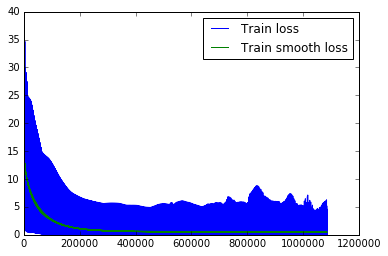

In [4]:
# Hyper-parameters
time_step = 10 # width, minibatch size and test sample size as well
num_layers = 2 # depth
n_iter = 300 # epochs
alpha = 1e-4 # learning_rate
print_after = 1 # n_iter//10 # print training loss, valid, and test
num_hidden_units = 64 # num_hidden_units in hidden layer
num_input_units = len(char_to_idx) # vocab_size = len(char_to_idx)

# Build the network and learning it or optimizing it using SGD
net = GRU(D=num_input_units, H=num_hidden_units, L=num_layers, char2idx=char_to_idx, idx2char=idx_to_char)

# Start learning using BP-SGD-ADAM
adam_rnn(nn=net, X_train=X, y_train=y, alpha=alpha, mb_size=time_step, n_iter=n_iter, print_after=print_after)

# # Display the learning curve and losses for training, validation, and testing
# %matplotlib inline
# %config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

plt.plot(net.losses['train'], label='Train loss')
plt.plot(net.losses['smooth train'], label='Train smooth loss')
plt.legend()
plt.show()